# 测试阶段攻击实验

In [1]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

np.set_printoptions(suppress=True)

Using TensorFlow backend.


## 1. 设定参数

In [2]:
batch_size = 128
num_classes = 10
epochs = 12
img_rows, img_cols = 28, 28

## 2. 处理数据

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data(already_path="data/mnist.npz")

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## 3. 建立模型

In [4]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

W0301 17:18:42.595757  5088 deprecation.py:506] From D:\dev_tools\anaconda\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W0301 17:18:42.623656  5088 module_wrapper.py:139] From D:\dev_tools\anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0301 17:19:07.027828  5088 module_wrapper.py:139] From D:\dev_tools\anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 26s 428us/step - loss: 0.2648 - accuracy: 0.9187 - val_loss: 0.0595 - val_accuracy: 0.9810
Epoch 2/12
60000/60000 [==============================] - 14s 232us/step - loss: 0.0921 - accuracy: 0.9733 - val_loss: 0.0381 - val_accuracy: 0.9877
Epoch 3/12
60000/60000 [==============================] - 13s 224us/step - loss: 0.0680 - accuracy: 0.9795 - val_loss: 0.0361 - val_accuracy: 0.9867
Epoch 4/12
60000/60000 [==============================] - 13s 224us/step - loss: 0.0562 - accuracy: 0.9832 - val_loss: 0.0331 - val_accuracy: 0.9893
Epoch 5/12
60000/60000 [==============================] - 13s 224us/step - loss: 0.0472 - accuracy: 0.9858 - val_loss: 0.0291 - val_accuracy: 0.9905
Epoch 6/12
60000/60000 [==============================] - 14s 228us/step - loss: 0.0433 - accuracy: 0.9870 - val_loss: 0.0315 - val_accuracy: 0.9893
Epoch 7/12
60000/60000 [==============================] 

## 4. 开始攻击

In [165]:
import numpy as np
from matplotlib import pyplot as plt

### 4.1 找到高威胁测试样本

In [169]:
atk_score_dict = {}
for test_index in range(x_test.shape[0]):
    sig_score = model.evaluate(np.array([x_test[test_index]]), np.array([y_test[test_index]]), verbose=0)[0]
    atk_score_dict[sig_score] = test_index

att_scores = np.array(list(atk_score_dict.keys()))
sorted_scores = np.sort(att_scores)[-10:]
att_test_index= [atk_score_dict[i] for i in sorted_scores]

### 4.2 观看高威胁样本

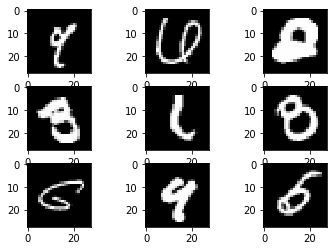

In [181]:
danger_test = [x_test[i] for i in att_test_index]
for num in range(9):
    plt.subplot(3,3,num+1)
    plt.imshow(danger_test[num].squeeze(), cmap='gray')
plt.show()

### 4.3 使用特征矩阵 | 特征值的攻击

In [188]:
danger_9 = x_test[att_test_index[0]].squeeze()
danger_9.shape

(28, 28)

In [189]:
eig, fea = np.linalg.eig(danger_9)

In [192]:
fea.shape

(28, 28)

D:\dev_tools\anaconda\lib\site-packages\ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


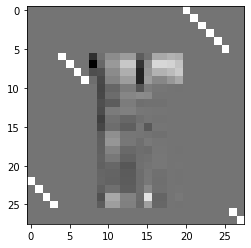

In [226]:
plt.imshow(fea.astype(np.float32),cmap='gray')

In [250]:
ori_a = np.array([x_test[7]])
ori_b = np.array([x_test[9]])
l_a = np.array([y_test[7]])
l_b = np.array([y_test[9]])

att_a = ori_a + np.array([np.expand_dims(fea,2)])*0.5
att_b = ori_b + np.array([np.expand_dims(fea,2)])
att_a = att_a.astype(np.float32)
att_b = att_b.astype(np.float32)

r_ori_a = model.evaluate(ori_a, l_a, verbose=0)[0]
r_ori_b = model.evaluate(ori_b, l_b, verbose=0)[0]

r_att_a = model.evaluate(att_a, l_a, verbose=0)[0]
r_att_b = model.evaluate(att_b, l_b, verbose=0)[0]

print("原图 A 的 Loss:{} | 攻击图 A 的 Loss:{}".format(r_ori_a, r_att_a))
print("原图 B 的 Loss:{} | 攻击图 B 的 Loss:{}".format(r_ori_b, r_att_b))

if r_ori_a < r_att_a:
    print("A 图攻击成功")
if r_ori_b < r_att_b:
    print("B 图攻击成功")

原图 A 的 Loss:8.4638240878121e-06 | 攻击图 A 的 Loss:0.00029392691794782877
原图 B 的 Loss:1.311301275563892e-06 | 攻击图 B 的 Loss:0.01260386686772108
A 图攻击成功
B 图攻击成功


D:\dev_tools\anaconda\lib\site-packages\ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  
D:\dev_tools\anaconda\lib\site-packages\ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


### 4.4 攻击方案1 图像可视化

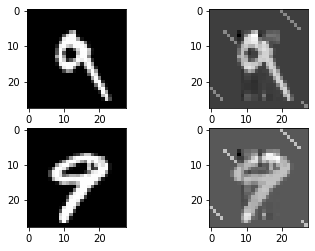

In [251]:
plt.subplot(2,2,1)
plt.imshow(ori_a.squeeze(), cmap='gray')
plt.subplot(2,2,2)
plt.imshow(att_a.squeeze(), cmap='gray')
plt.subplot(2,2,3)
plt.imshow(ori_b.squeeze(), cmap='gray')
plt.subplot(2,2,4)
plt.imshow(att_b.squeeze(), cmap='gray')

plt.show()

### 4.5 使用均值与标准差形成一般分布进行攻击

In [215]:
mean = danger_9.mean()
std = danger_9.std()
print("均值：{}， 标准差：{}".format(mean,std))

均值：0.09338735789060593， 标准差：0.2637976109981537


In [237]:
var = np.array(np.random.normal(loc=mean, scale=std, size=(28,28,1)))

ori_a = np.array([x_test[7]])
ori_b = np.array([x_test[9]])
l_a = np.array([y_test[7]])
l_b = np.array([y_test[9]])

att2_a = ori_a + var
att2_b = ori_b + var
att2_a = att2_a.astype(np.float32)
att2_b = att2_b.astype(np.float32)

r_ori_a = model.evaluate(ori_a, l_a, verbose=0)[0]
r_ori_b = model.evaluate(ori_b, l_b, verbose=0)[0]

r_att2_a = model.evaluate(att2_a, l_a, verbose=0)[0]
r_att2_b = model.evaluate(att2_b, l_b, verbose=0)[0]

print("原图 A 的 Loss:{} | 攻击图 A 的 Loss:{}".format(r_ori_a, r_att2_a))
print("原图 B 的 Loss:{} | 攻击图 B 的 Loss:{}".format(r_ori_b, r_att2_b))

if r_ori_a < r_att_a:
    print("A 图攻击成功")
if r_ori_b < r_att_b:
    print("B 图攻击成功")

原图 A 的 Loss:8.4638240878121e-06 | 攻击图 A 的 Loss:0.04645919054746628
原图 B 的 Loss:1.311301275563892e-06 | 攻击图 B 的 Loss:0.0006930810050107539
A 图攻击成功
B 图攻击成功


### 4.6 攻击方案1 图像可视化

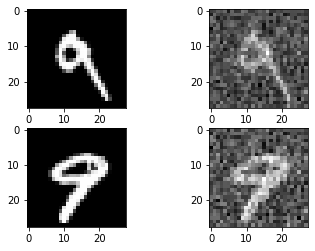

In [233]:
plt.subplot(2,2,1)
plt.imshow(ori_a.squeeze(), cmap='gray')
plt.subplot(2,2,2)
plt.imshow(att2_a.squeeze(), cmap='gray')
plt.subplot(2,2,3)
plt.imshow(ori_b.squeeze(), cmap='gray')
plt.subplot(2,2,4)
plt.imshow(att2_b.squeeze(), cmap='gray')

plt.show()